In [170]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import re
import seaborn
from lxml import html
import matplotlib

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [171]:
user_id = 1863174

In [172]:
# establishing session
s = requests.Session() 
s.headers.update({
        'Referer': 'http://www.kinopoisk.ru',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:45.0) Gecko/20100101 Firefox/45.0'
    })

# User data

In [195]:
def load_user_data(user_id, page, session):
    url = 'http://www.kinopoisk.ru/user/%d/votes/list/ord/date/page/%d/#list' % (user_id, page)
    # print url
    request = session.get(url)
    return request.text

def contain_movies_data(text):
    soup = BeautifulSoup(text)
    film_list = film_list = soup.find('div', {'class': 'profileFilmsList'})
    return film_list is not None

def read_file(filename):
    with open(filename) as input_file:
        text = input_file.read()
    return text

def parse_user_datafile_bs(filename):
    results = []
    text = read_file(filename)
        
    soup = BeautifulSoup(text)
    film_list = film_list = soup.find('div', {'class': 'profileFilmsList'})
    items = film_list.find_all('div', {'class': ['item', 'item even']})
    for item in items:
        # getting movie_id
        movie_link = item.find('div', {'class': 'nameRus'}).find('a').get('href')
        movie_desc = item.find('div', {'class': 'nameRus'}).find('a').text
        movie_id = re.findall('\d+', movie_link)[0]
        
        # getting english name
        name_eng = item.find('div', {'class': 'nameEng'}).text
        
        #getting watch time
        watch_datetime = item.find('div', {'class': 'date'}).text
        date_watched, time_watched = re.match('(\d{2}\.\d{2}\.\d{4}), (\d{2}:\d{2})', watch_datetime).groups()
        
        # getting user rating
        user_rating = item.find('div', {'class': 'vote'}).text
        if user_rating:
            user_rating = int(user_rating)
            
        results.append({
                'movie_id': movie_id,
                'name_eng': name_eng,
                'date_watched': date_watched,
                'time_watched': time_watched,
                'user_rating': user_rating,
                'movie_desc': movie_desc
            })
    return results

def parse_user_datafile_lxml(filename):
    results = []
    text = read_file(filename)
    
    tree = html.fromstring(text)
    
    film_list_lxml = tree.xpath('//div[@class = "profileFilmsList"]')[0]
    items_lxml = film_list_lxml.xpath('//div[@class = "item even" or @class = "item"]')  
    for item_lxml in items_lxml:
        # getting movie id
        movie_link = item_lxml.xpath('.//div[@class = "nameRus"]/a/@href')[0]
        movie_desc = item_lxml.xpath('.//div[@class = "nameRus"]/a/text()')[0]
        movie_id = re.findall('\d+', movie_link)[0]

        # getting english name
        name_eng = item_lxml.xpath('.//div[@class = "nameEng"]/text()')[0]

        #getting watch time
        watch_datetime = item_lxml.xpath('.//div[@class = "date"]/text()')[0]
        date_watched, time_watched = re.match('(\d{2}\.\d{2}\.\d{4}), (\d{2}:\d{2})', watch_datetime).groups()

        # getting user rating
        user_rating = item_lxml.xpath('.//div[@class = "vote"]/text()')
        if user_rating:
            user_rating = int(user_rating[0])
            
        results.append({
                'movie_id': movie_id,
                'name_eng': name_eng,
                'date_watched': date_watched,
                'time_watched': time_watched,
                'user_rating': user_rating,
                'movie_desc': movie_desc
            })
    return results

In [196]:
# loading user viewed files
page = 1
while True:
    print 'Loading page #%d' % (page)
    data = load_user_data(user_id, page, s)
    if contain_movies_data(data):
        with open('./user_data/page_%d.html' % (page), 'w') as output_file:
            output_file.write(data.encode('cp1251'))
            page += 1
    else:
            break

Loading page #1
Loading page #2
Loading page #3
Loading page #4
Loading page #5
Loading page #6
Loading page #7
Loading page #8
Loading page #9
Loading page #10
Loading page #11
Loading page #12
Loading page #13
Loading page #14
Loading page #15
Loading page #16
Loading page #17
Loading page #18
Loading page #19
Loading page #20
Loading page #21
Loading page #22


In [197]:
# parsing user data
results = []
for filename in os.listdir('./user_data/'):
    results.extend(parse_user_datafile_bs('./user_data/' + filename))

In [198]:
user_data_df = pd.DataFrame(results)
user_data_df['user_rating'] = pd.to_numeric(user_data_df.user_rating)

In [199]:
movies = user_data_df.movie_id.unique().tolist()

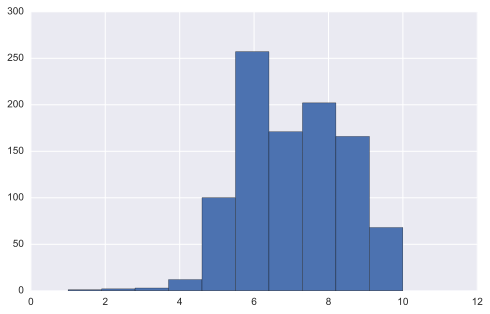

In [207]:
user_data_df.user_rating.hist()

In [211]:
user_data_df['date_watched'] = pd.to_datetime(user_data_df.date_watched, format = '%d.%m.%Y')

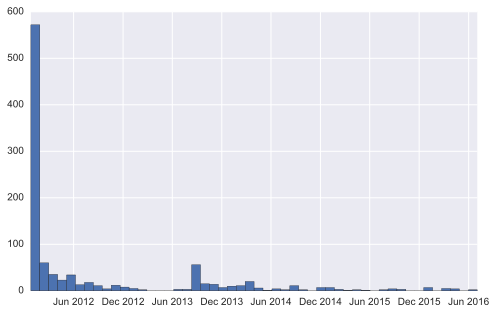

In [212]:
user_data_df.date.hist(bins = 50)

In [219]:
user_data_df[780:790]

,date_watched,movie_desc,movie_id,name_eng,time_watched,user_rating,date
780,2012-12-09,Турист (2010),428715,The Tourist,12:48,8.0,2012-09-12
781,2012-11-18,1+1 (2011),535341,Intouchables,23:29,6.0,2012-11-18
782,2012-11-18,Третий лишний (2012),507817,Ted,23:26,5.0,2012-11-18
783,2012-11-11,Опасные пассажиры поезда 123 (2009),400582,The Taking of Pelham 1 2 3,22:54,5.0,2012-11-11
784,2012-11-11,Пароль «Рыба-меч» (2001),849,Swordfish,22:46,5.0,2012-11-11
785,2012-11-03,Ищу друга на конец света (2011),464573,Seeking a Friend for the End of the World,22:44,7.0,2012-03-11
786,2012-10-28,Казино Рояль (2006),49844,Casino Royale,12:51,8.0,2012-10-28
787,2012-10-28,Золушка (1947),45398,,12:33,8.0,2012-10-28
788,2012-10-28,Морозко (1964),46701,,12:32,NaN,2012-10-28
789,2012-10-28,Темный рыцарь: Возрождение легенды (2012),437410,The Dark Knight Rises,00:12,10.0,2012-10-28


# Movie Data

In [12]:
def load_movie_data(movie_id, session):
    url = 'http://www.kinopoisk.ru/film/%s/' % (movie_id)
    # print url
    request = session.get(url)
    return request.text

In [13]:
# loading movie data
for movie_id in movies:
    time.sleep(1)
    print movie_id
    tmp = load_movie_data(movie_id, s)
    with open('./movie_data/%s.html' % (movie_id), 'w') as output_file:
        output_file.write(tmp.encode('cp1251'))

841335
693126
841770
899691
522876
5619
342
775276
677893
838856
462360
309423
5056
623658
447
338
333
714888
12090
859908
518042
678549
694051
645118
453406
93377
64021
401522
635772
386
259281
759558
705356
681831
263531
582158
258687
5286
46225
64451
22328
661911
308123
740644
596318
692861
77450
462048
277549
807630
2987
724
8151
19174
15259
6888
9411
2408
278171
195563
102128
461799
276478
106165
23275
36786
81530
883
3608
676
9393
198009
70955
10074
396472
14000
42172
43009
42991
8232
438262
551
387388
663
195435
46792
20903
45086
38903
41562
45446
44985
45864
256498
23737
450725
81516
4456
8033
2011
18120
7510
8161
8125
46421
44745
394580
438890
77038
45780
18566
44718
46223
186762
573759
251884
391129
45781
42326
45779
256551
405644
634
2441
12276
9552
251879
77441
47984
6522
6032
7096
4120
251613
4250
77466
2053
43104
16115
8143
1996
2333
48236
416802
468194
393872
276762
161261
195394
11130
5330
1949
161066
437503
261365
3793
8486
784
378140
463149
2768
89597
10970
15635
5682

In [209]:
def parse_movie_datafile(filename):
    with open('./movie_data/' + filename) as input_file:
        text = input_file.read()
        
    movie_id = filename.replace('.html', '')
    
    soup = BeautifulSoup(text)
    
    name_eng = soup.find('span', {'itemprop': 'alternativeHeadline'}).text
    name_rus = soup.find('h1', {'class': 'moviename-big'}).text

    kp_rating = float(soup.find('span', {'class': 'rating_ball'}).text)
    
    critics_rating = None
    critics_rating_block = soup.find('div', {'class': 'criticsRating'})
    if critics_rating_block:
        critics_rating_num_block = critics_rating_block.find('div', {'class': 'ratingNum'})
        if critics_rating_num_block:
            critics_rating = int(critics_rating_num_block.find('span').text)
      
    imdb_rating = None
    imdb_block_text = soup.find('div', {'class': 'block_2'}).find(text = re.compile('^IMDb'))
    if imdb_block_text:
        imdb_rating = imdb_block_text.split()[1]
    
    info_table = soup.find('table', {'class': 'info'})
    
    movie_year = int(info_table.find('td', {'class': 'type'}, text = u'год').nextSibling.nextSibling.text[:5])
    movie_duration = int(info_table.find('td', {'class': 'type'}, text = u'время').nextSibling.text.split()[0])
    genres = map(lambda x: x.text, info_table.find('span', {'itemprop': 'genre'}).find_all('a'))
    countries = map(lambda x: x.text, info_table.find('td', {'class': 'type'}, text = u'страна').nextSibling.nextSibling.find_all('a'))
    
    movie = {
    'movie_id': movie_id,
    'name_eng': name_eng,
    'name_rus': name_rus,
    'kp_rating': kp_rating,
    'critics_rating': critics_rating,
    'imdb_rating': imdb_rating,
    'movie_year': movie_year,
    'movie_duration': movie_duration,
    'genres': genres,
    'countries': countries
    }
    
    return movie

In [210]:
movies = []

for filename in os.listdir('./movie_data/'):
    print filename
    if filename.find('.html') != -1:
        movie = parse_movie_datafile(filename)
        movies.append(movie)

.DS_Store
10074.html
10156.html
102124.html
102125.html
102128.html
102130.html
102146.html
102147.html
102185.html
102198.html
102201.html
102203.html
103414.html
103627.html
103733.html
103734.html
103791.html
104893.html
104904.html
104905.html
104927.html
104992.html
106165.html
1091.html
10970.html
11130.html
111543.html
11637.html
119975.html
12090.html
12192.html
12198.html
12276.html
12330.html
13469.html
14000.html
14339.html
14349.html
14940.html
15204.html
15259.html
15527.html
1563.html
15635.html
1564.html
160910.html
160914.html
160958.html
160983.html
161046.html
161066.html
161104.html
16115.html
161194.html
161252.html
161261.html
161265.html
161917.html
164089.html
16445.html
1656.html
167491.html
16953.html
171869.html
171922.html
17643.html
17721.html
17754.html
17836.html
17839.html
178580.html
178707.html
178710.html
178722.html
179084.html
1794.html
1796.html
180577.html
181150.html
181153.html
18120.html
18347.html
18348.html
184417.html
184432.html
18566.html
1

In [221]:
movie_data_df = pd.DataFrame(movies)

In [222]:
fin_df = user_data_df.merge(movie_data_df, on = 'movie_id')
fin_df[780:790]

,date_watched,movie_desc,movie_id,name_eng_x,time_watched,user_rating,date,countries,critics_rating,genres,imdb_rating,kp_rating,movie_duration,movie_year,name_eng_y,name_rus
780,2012-12-09,Турист (2010),428715,The Tourist,12:48,8.0,2012-09-12,"[США, Франция, Италия]",20.0,"[боевик, триллер, мелодрама]",6.00,6.754,103,2010,The Tourist,Турист
781,2012-11-18,1+1 (2011),535341,Intouchables,23:29,6.0,2012-11-18,[Франция],75.0,"[драма, комедия, биография]",8.60,8.829,112,2011,Intouchables,1+1
782,2012-11-18,Третий лишний (2012),507817,Ted,23:26,5.0,2012-11-18,[США],68.0,"[фэнтези, комедия]",7.00,6.735,106,2012,Ted,Третий лишний
783,2012-11-11,Опасные пассажиры поезда 123 (2009),400582,The Taking of Pelham 1 2 3,22:54,5.0,2012-11-11,"[США, Великобритания]",51.0,"[триллер, боевик, криминал]",6.40,7.049,102,2009,The Taking of Pelham 1 2 3,Опасные пассажиры поезда 123
784,2012-11-11,Пароль «Рыба-меч» (2001),849,Swordfish,22:46,5.0,2012-11-11,"[США, Австралия]",26.0,"[боевик, триллер, криминал]",6.50,7.257,99,2001,Swordfish,Пароль «Рыба-меч»
785,2012-11-03,Ищу друга на конец света (2011),464573,Seeking a Friend for the End of the World,22:44,7.0,2012-03-11,"[США, Сингапур, Малайзия, Индонезия]",56.0,"[мелодрама, драма, комедия, фантастика]",6.70,6.656,101,2011,Seeking a Friend for the End of the World,Ищу друга на конец света
786,2012-10-28,Казино Рояль (2006),49844,Casino Royale,12:51,8.0,2012-10-28,"[Великобритания, Чехия, США, Германия, Багамы]",95.0,"[боевик, триллер, приключения]",8.00,7.753,139,2006,Casino Royale,Казино Рояль
787,2012-10-28,Золушка (1947),45398,,12:33,8.0,2012-10-28,[СССР],NaN,"[мюзикл, фэнтези, мелодрама, комедия, семейный]",7.80,8.001,84,1947,,Золушка
788,2012-10-28,Морозко (1964),46701,,12:32,NaN,2012-10-28,[СССР],NaN,"[фэнтези, мелодрама, комедия, семейный]",6.00,8.015,84,1964,,Морозко
789,2012-10-28,Темный рыцарь: Возрождение легенды (2012),437410,The Dark Knight Rises,00:12,10.0,2012-10-28,"[США, Великобритания]",NaN,"[фантастика, боевик, триллер, драма, криминал]",8.50,8.165,165,2012,The Dark Knight Rises,Темный рыцарь: Возрождение легенды
